In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# Load datasets
def load_data():
    customers_df = pd.read_csv("C:/Users/om wanjari/Downloads/Customers.csv")
    products_df = pd.read_csv('C:/Users/om wanjari/Downloads/Products.csv')
    transactions_df = pd.read_csv('C:/Users/om wanjari/Downloads/Transactions.csv')
    return customers_df, products_df, transactions_df


In [12]:
# customer features
def preprocess_customer_features(customers_df):
    # Convert SignupDate to days since first signup
    customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
    min_date = customers_df['SignupDate'].min()
    customers_df['DaysSinceSignup'] = (customers_df['SignupDate'] - min_date).dt.days
      # Encode Region
    region_dummies = pd.get_dummies(customers_df['Region'], prefix='Region')
    customers_df = pd.concat([customers_df, region_dummies], axis=1)
    
    return customers_df


In [13]:
# transaction features
def create_transaction_features(transactions_df, products_df):
    # Merge transactions with products to get category information
    trans_prod = transactions_df.merge(products_df, on='ProductID')
    
    customer_features = trans_prod.groupby('CustomerID').agg({
        'TransactionID': 'count',  # total transactions
        'TotalValue': ['sum', 'mean'],  # Total spend and avg transaction value
        'Quantity': ['sum', 'mean'],  # Total quantity and average quantity per transaction
        'Category': lambda x: x.mode().iloc[0] if not x.empty else None  # Most frequent
    }).reset_index()
    
    # Flatten column names
    customer_features.columns = ['CustomerID', 'TransactionCount', 'TotalSpend','AvgTransactionValue', 'TotalQuantity', 'AvgQuantity','MostFrequentCategory']
    
    # Create category dummies
    category_dummies = pd.get_dummies(customer_features['MostFrequentCategory'],prefix='Category')
    customer_features = pd.concat([customer_features, category_dummies], axis=1)
    
    return customer_features


In [26]:
class CustomerLookAlikeModel:
    def __init__(self, n_components=None):
        self.scaler = StandardScaler()
        self.pca = PCA(n_components=n_components)
        self.similarity_matrix = None
        self.processed_data = None
        self.customer_ids = None
        self.feature_columns = None
        
    def prepare_features(self, customers_df, transaction_features):
        # Merge customer and transaction features
        combined_features = customers_df.merge(transaction_features, on='CustomerID', how='left')
        
        # Fill NaN values
        combined_features = combined_features.fillna(0)
        
        # Select numerical and encoded categorical features
        self.feature_columns = ['DaysSinceSignup', 'TransactionCount', 'TotalSpend', 
                              'AvgTransactionValue', 'TotalQuantity', 'AvgQuantity'] + \
                             [col for col in combined_features.columns if col.startswith(('Region_', 'Category_'))]        
        return combined_features[self.feature_columns]
    
    def fit(self, features, customer_ids):
        self.customer_ids = customer_ids
        scaled_features = self.scaler.fit_transform(features)
        
        # Apply PCA 
        if self.pca.n_components is not None:
            self.processed_data = self.pca.fit_transform(scaled_features)
            # Calculate explained variance
            explained_variance = np.sum(self.pca.explained_variance_ratio_)
            print(f"Explained variance ratio with {self.pca.n_components} components: {explained_variance:.3f}")
        else:
            self.processed_data = scaled_features
        
        # similarity matrix
        self.similarity_matrix = cosine_similarity(self.processed_data)
        return self
    
    def find_lookalikes(self, customer_id, n_similar=3):
        if customer_id not in self.customer_ids:
            print(f"Customer ID {customer_id} not found in the dataset. Skipping...")
            return []
        
        customer_idx = list(self.customer_ids).index(customer_id)
        similarity_scores = self.similarity_matrix[customer_idx]
        
        # most similar customer
        similar_indices = np.argsort(similarity_scores)[::-1][1:n_similar+1]
        similar_customers = [
            {
                'customer_id': self.customer_ids[idx],
                'similarity_score': similarity_scores[idx]
            }
            for idx in similar_indices
        ]
        
        return similar_customers


In [17]:
# Visualization functions
def visualize_top_features(feature_importance):
    top_features = feature_importance.sum().sort_values(ascending=False).head(10)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_features.values, y=top_features.index, palette="viridis",hue = top_features.index)
    plt.title("Top 10 Most Important Features")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.show()

def visualize_similarity_scores(results):
    similarity_scores = [score for customer in results.values() for _, score in customer]
    plt.figure(figsize=(10, 6))
    sns.histplot(similarity_scores, bins=20, kde=True, color="blue")
    plt.title("Distribution of Similarity Scores")
    plt.xlabel("Similarity Score")
    plt.ylabel("Frequency")
    plt.show()


Explained variance ratio with 10 components: 0.995
All CustomerID values are present in the dataset.

Model Quality Metrics:
Average Similarity Score: 0.873

Top 5 Most Important Features:
AvgTransactionValue     2.389367
AvgQuantity             2.389267
Category_Home Decor     2.293766
Region_North America    2.280373
Region_South America    2.270361
dtype: float64


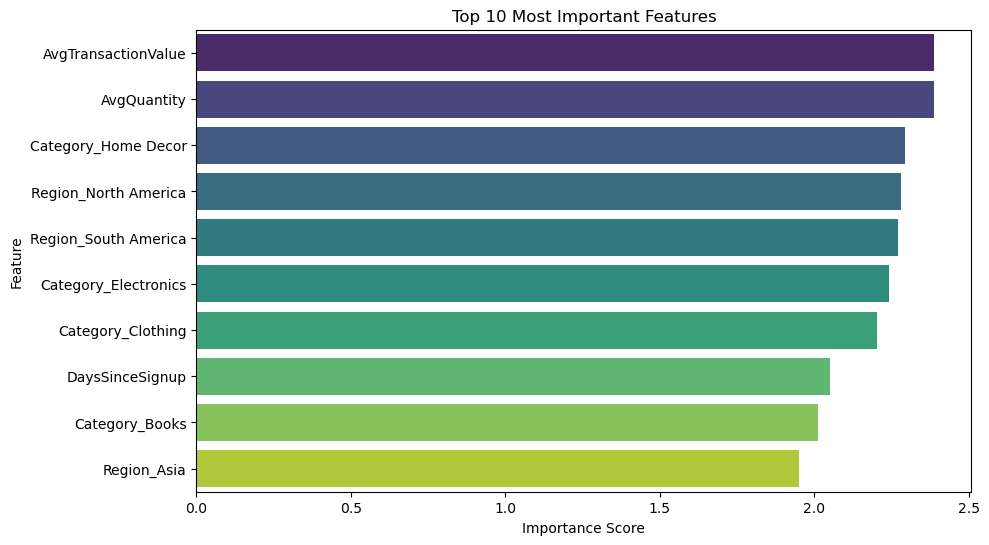

   CustomerID Lookalike1_ID  Lookalike1_Score Lookalike2_ID  Lookalike2_Score  \
0       C0001         C0192             0.907         C0112             0.906   
1       C0002         C0106             0.945         C0134             0.896   
2       C0003         C0195             0.860         C0052             0.846   
3       C0004         C0165             0.966         C0155             0.921   
4       C0005         C0007             0.959         C0186             0.924   
5       C0006         C0168             0.914         C0171             0.896   
6       C0007         C0005             0.959         C0140             0.923   
7       C0008         C0065             0.840         C0059             0.800   
8       C0009         C0198             0.907         C0103             0.888   
9       C0010         C0062             0.950         C0111             0.799   
10      C0011         C0174             0.939         C0153             0.912   
11      C0012         C0195 

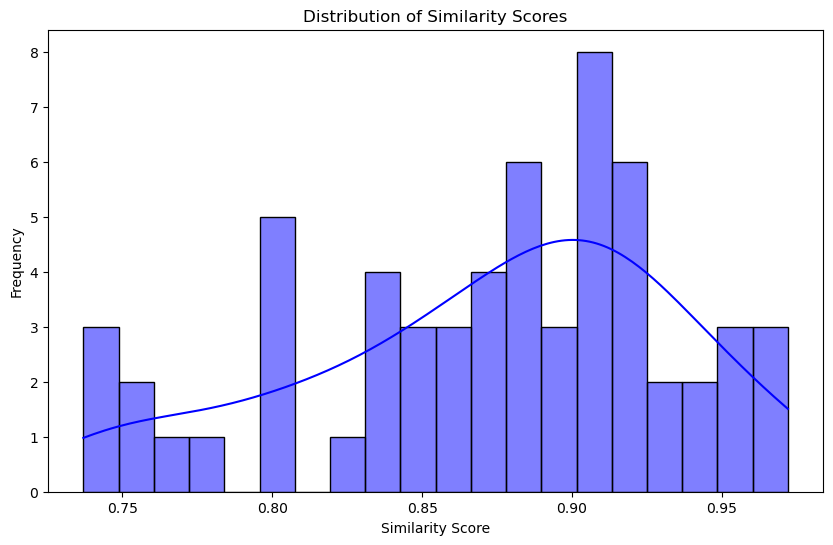

In [27]:
def main():
    customers_df, products_df, transactions_df = load_data()
    
    processed_customers_df = preprocess_customer_features(customers_df)
    
    transaction_features = create_transaction_features(transactions_df, products_df)
    
    model = CustomerLookAlikeModel(n_components=10)
    features = model.prepare_features(processed_customers_df, transaction_features)
    model.fit(features, processed_customers_df['CustomerID'].values)
    
    # Verify customerid exist
    first_20_customers = processed_customers_df['CustomerID'].values[:20]
    missing_customers = [cust_id for cust_id in first_20_customers if cust_id not in model.customer_ids]

    if missing_customers:
        print("The following CustomerID values are missing in the dataset:", missing_customers)
    else:
        print("All CustomerID values are present in the dataset.")
    
    results = {}
    for customer_id in first_20_customers:
        similar_customers = model.find_lookalikes(customer_id, n_similar=3)
        if similar_customers:  
            results[customer_id] = [
                (c['customer_id'], round(c['similarity_score'], 3))
                for c in similar_customers
            ]
    
    output_data = []
    for cust_id, lookalikes in results.items():
        output_data.append({
            'CustomerID': cust_id,
            'Lookalike1_ID': lookalikes[0][0],
            'Lookalike1_Score': lookalikes[0][1],
            'Lookalike2_ID': lookalikes[1][0],
            'Lookalike2_Score': lookalikes[1][1],
            'Lookalike3_ID': lookalikes[2][0],
            'Lookalike3_Score': lookalikes[2][1]
        })
    
    output_df = pd.DataFrame(output_data)
    output_df.to_csv('Lookalike.csv', index=False)
    
    avg_similarity_score = np.mean([score for customer in results.values() 
                                  for _, score in customer])
    print(f"\nModel Quality Metrics:")
    print(f"Average Similarity Score: {avg_similarity_score:.3f}")
    
    if hasattr(model.pca, 'components_'):
        feature_importance = pd.DataFrame(
            np.abs(model.pca.components_),
            columns=model.feature_columns
        )
        print("\nTop 5 Most Important Features:")
        top_features = feature_importance.sum().sort_values(ascending=False).head()
        print(top_features)
        
        visualize_top_features(feature_importance)
        print(output_df)
        output_df.to_csv('Om_Wanjari_Lookalike.csv', index=False)

    
    visualize_similarity_scores(results)

if __name__ == "__main__":
    main()
